In [87]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention, Concatenate,MultiHeadAttention,LayerNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv("hin.txt", sep="\t", header=None, names=["english", "hindi", "source"])

In [17]:
df=df.drop(columns=["source"])

In [18]:

max_length_english = df["english"].apply(lambda x: len(x.split())).max()
max_length_hindi = df["hindi"].apply(lambda x: len(x.split())).max()

print("Max length of English sentence: ", max_length_english)
print("Max length of Hindi sentence: ", max_length_hindi)

Max length of English sentence:  22
Max length of Hindi sentence:  25


In [10]:
def load_data(filepath="hin.txt"):
    df = pd.read_csv(filepath, sep="\t", header=None, names=["english", "hindi", "source"])
    return df['english'].tolist(), df['hindi'].tolist()

In [11]:
def preprocess_data(english_texts, hindi_texts, max_len):
    # Tokenize the texts
    eng_tokenizer = Tokenizer()
    hin_tokenizer = Tokenizer()
    eng_tokenizer.fit_on_texts(english_texts)
    hin_tokenizer.fit_on_texts(hindi_texts)

    # Convert text to sequences
    eng_sequences = eng_tokenizer.texts_to_sequences(english_texts)
    hin_sequences = hin_tokenizer.texts_to_sequences(hindi_texts)

    # Pad sequences
    eng_data = pad_sequences(eng_sequences, maxlen=max_len, padding='post')
    hin_data = pad_sequences(hin_sequences, maxlen=max_len, padding='post')

    return eng_data, hin_data, eng_tokenizer, hin_tokenizer

In [80]:
def create_model(input_vocab_size, output_vocab_size, max_len):
    # Encoder
    encoder_inputs = Input(shape=(max_len,))
    enc_emb = Embedding(input_vocab_size, 256)(encoder_inputs)
    encoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

    # Decoder
    decoder_inputs = Input(shape=(max_len-1,))
    dec_emb = Embedding(output_vocab_size, 256)(decoder_inputs)
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # Attention mechanism
    multi_head_attention = MultiHeadAttention(num_heads=6, key_dim=256)
    attention_output = multi_head_attention(query=decoder_outputs, value=encoder_outputs, key=encoder_outputs)
    
    # Concatenate attention output with decoder output
    decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    # Dense layer to generate output tokens
    decoder_dense = Dense(output_vocab_size, activation='softmax')
    output = decoder_dense(decoder_concat)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [70]:
def train_model(model, eng_data, hin_data, batch_size, epochs):
    # Shift the Hindi sequences by one for decoder input and output
    history = model.fit(
        [eng_data, hin_data[:, :-1]],  # Inputs: English and shifted Hindi
        hin_data[:, 1:],               # Outputs: Shifted Hindi target
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2
    )
    return history


In [14]:
def plot_metrics(history):
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [71]:
file_path = "hin.txt"
english_texts, hindi_texts = load_data(file_path)
max_len = 25
eng_data, hin_data, eng_tokenizer, hin_tokenizer = preprocess_data(english_texts, hindi_texts, max_len)

In [83]:
input_vocab_size = len(eng_tokenizer.word_index) + 1
output_vocab_size = len(hin_tokenizer.word_index) + 1
model = create_model(input_vocab_size, output_vocab_size, max_len)

In [84]:
batch_size = 64
epochs = 50
history = train_model(model, eng_data, hin_data, batch_size, epochs)

Epoch 1/50
35/35 [==============================] - 8s 62ms/step - loss: 2.6580 - accuracy: 0.7671 - val_loss: 2.9760 - val_accuracy: 0.6264
Epoch 2/50
35/35 [==============================] - 1s 34ms/step - loss: 1.4487 - accuracy: 0.7899 - val_loss: 2.7610 - val_accuracy: 0.6264
Epoch 3/50
35/35 [==============================] - 1s 33ms/step - loss: 1.3824 - accuracy: 0.7906 - val_loss: 2.6811 - val_accuracy: 0.6305
Epoch 4/50
35/35 [==============================] - 1s 32ms/step - loss: 1.3332 - accuracy: 0.7945 - val_loss: 2.6761 - val_accuracy: 0.6323
Epoch 5/50
35/35 [==============================] - 1s 32ms/step - loss: 1.2904 - accuracy: 0.7981 - val_loss: 2.7023 - val_accuracy: 0.6323
Epoch 6/50
35/35 [==============================] - 1s 33ms/step - loss: 1.2546 - accuracy: 0.8001 - val_loss: 2.7141 - val_accuracy: 0.6328
Epoch 7/50
35/35 [==============================] - 1s 32ms/step - loss: 1.2216 - accuracy: 0.8022 - val_loss: 2.7278 - val_accuracy: 0.6344
Epoch 8/50
35

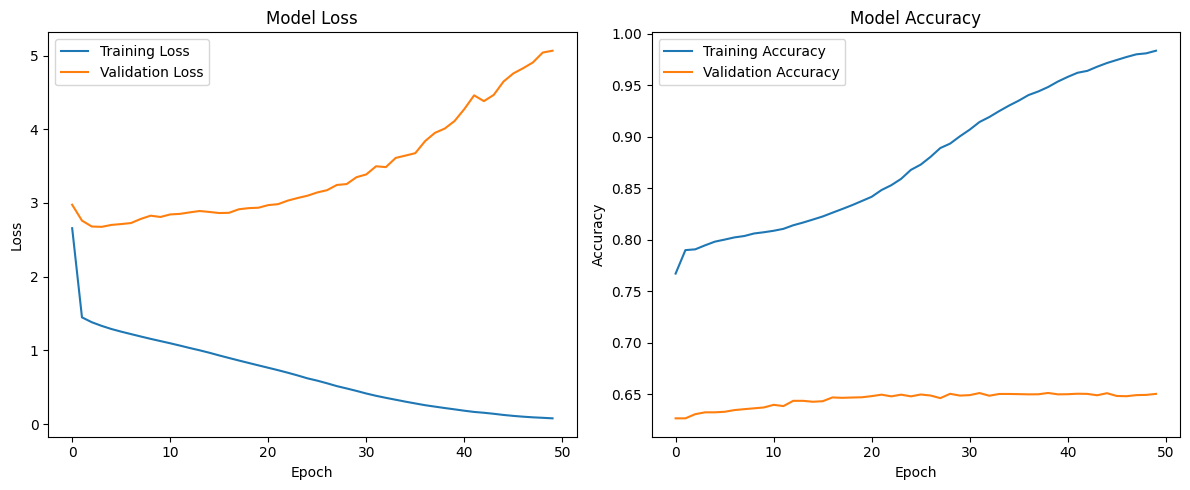

In [85]:
plot_metrics(history)